In [1]:
from simulation_utils import * 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import gpboost as gpb
import pdpbox
from pdpbox import pdp
sns.set()

In [4]:
def plot_random_effects(n, m, p, shared_gp=True, random_state=1, rho=0.1, kernel_var=1):

    # Create groups
    group = np.arange(n) # Variable that stores group IDs
    for i in range(m):
        group[i*p:(i+1)*p] = i

    # Incidence matrix relating grouped random effects to observations
    Z1 = np.zeros((n, m))
    for i in range(m):
        Z1[np.where(group==i), i] = 1

    # Simulate random (sorted) observation times for each group
    rng = np.random.default_rng(seed=random_state)


    times_arrays = [np.sort(rng.choice(100, size=p, replace=False, shuffle=False)) for i in range(m)] 


    times = np.concatenate(times_arrays)

    # Simulate GPs for the random effects part 
    GP_list = []
    np.random.seed(random_state)
    if shared_gp:
        # Simulate GPs with same parameters

        for arr in times_arrays:
            K = exponential_kernel(arr, arr, kernel_var, rho)
            g = np.random.multivariate_normal(mean=np.zeros(p), cov=K)
            GP_list.append(g)
    else:
        # Simulate GPs with different, random parameters
        for arr in times_arrays:
            kernel_var = scipy.stats.invgamma.rvs(1, loc=0, scale=10)
            rho = np.random.uniform(0.01, 1000)
            K = exponential_kernel(arr, arr, kernel_var, rho)
            g = np.random.multivariate_normal(mean=np.zeros(p), cov=K)
            GP_list.append(g)

    # Simulate outcome variable
    np.random.seed(random_state)
    sigma2 = 0.5 ** 2  # Error variance
    b = np.random.normal(size=m) # Simulate random effect intercept
    G = np.dot(Z1, b) + np.concatenate(GP_list) + 0.005 * np.concatenate(times_arrays) # Combine random effect intercept with GP

    group = rng.choice(m, size=1)[0]
    times , r_i = times_arrays[group] , G[group * p : (group+1) * p]
    plt.figure(figsize=(8,5)) 
    plt.plot(times, r_i, '-o')
    plt.title(f'rho: {rho}, sigma_2: {kernel_var}', fontsize=14)
    plt.xlabel('Times', fontsize=14)
    plt.ylabel('r_i', fontsize=14)
    
    #return np.concatenate(GP_list) # this is the b_i from below

## Plots for visualising the random effects of different data-generating processes (under a shared GP):

In particular, the random effects for the i-th group are specified as:

$$ \bm{r_i} = \alpha_i \bm{1}_{T_i} + \bm{b}_i + c \bm{t}_i,$$

where $c \in \mathbb{R}$ is a small constant, $\alpha_i \sim \mathcal{N}(0,1)$, $\bm{b_i} \sim \mathcal{N}( \bm{0}_{T_i} , \bm{K}_i )$ and $\bm{K}_i$ is the kernel matrix obtained by evaluating the exponential kernel between all observation times of the i-th group. 

### Keeping $\rho$ fixed and changing $\sigma^2$ (exponential kernel hyperparameters) 

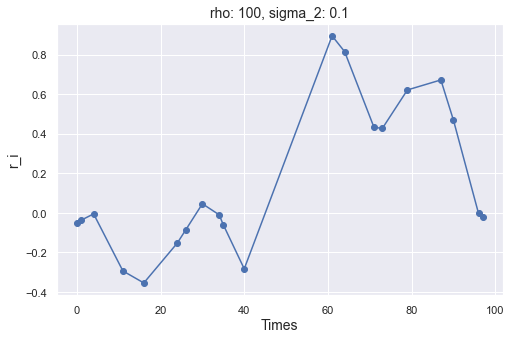

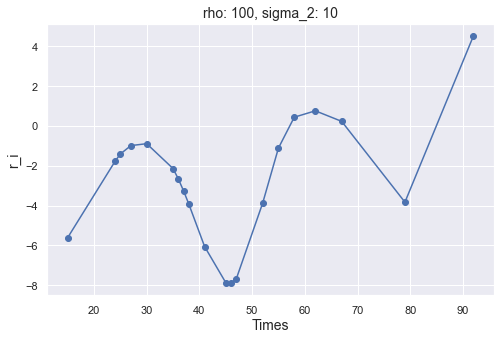

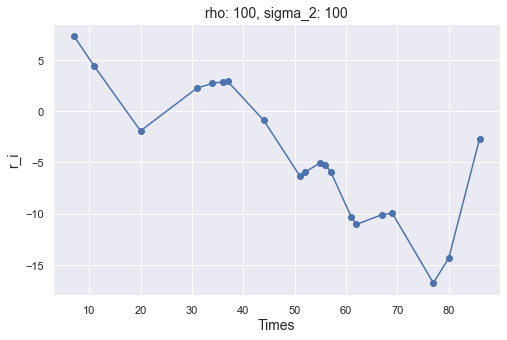

In [5]:
for i , s in enumerate([0.1, 10, 100]):
    plot_random_effects(n=1000, m=50, p=20, shared_gp=True, random_state=i, rho=100, kernel_var=s)

### Keeping $\sigma^2$ fixed and changing $\rho$ (exponential kernel hyperparameters) 

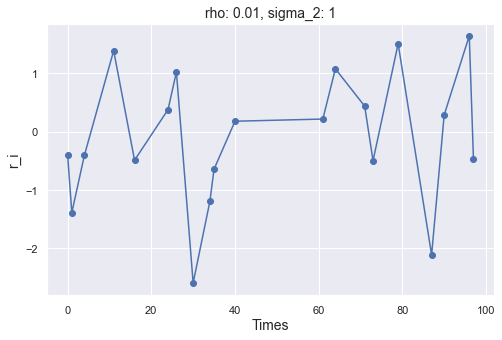

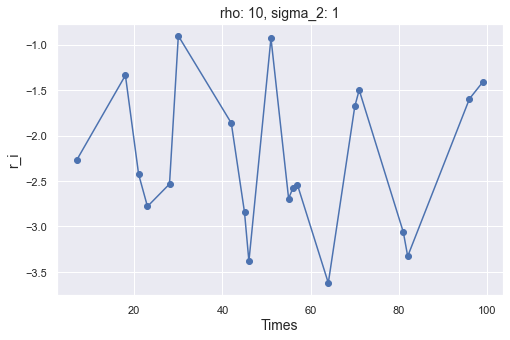

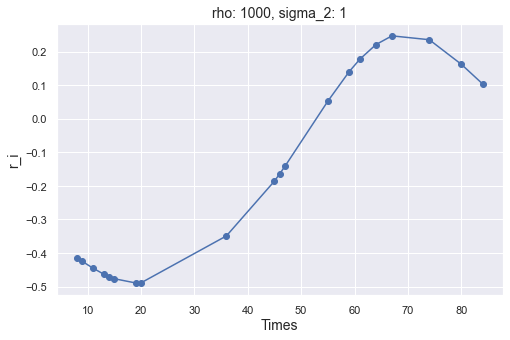

In [52]:
for i, r in enumerate([0.01, 10, 1000]):
    plot_random_effects(n=1000, m=50, p=20, shared_gp=True, random_state=3*i, rho=r, kernel_var=1)

In [2]:
n, m = 1000, 50  # Number of observations and groups
p = int(n/m) # Number of observations per group
data, X, y, F = generate_data(n, m, p, func='make_friedman3', shared_gp=True)


# Split training and test sets
group_sizes = data.groupby(['group']).size().to_numpy()
X_train, X_test, y_train, y_test, F_train, F_test = train_test_split_grouped_extrapolation(X, y, F, X['group'], test_size=0.2, random_state=1)

data_train = gpb.Dataset(data=X_train[['feature_1','feature_2','feature_3','feature_4']], label=y_train)

In [6]:
X

,group,times,feature_1,feature_2,feature_3,feature_4
0,0,27,41.702200,1302.406097,0.000114,4.023326
1,0,34,14.675589,276.510637,0.186260,4.455607
2,0,85,39.676747,1005.889907,0.419195,7.852195
3,0,142,20.445225,1560.181095,0.027388,7.704675
4,0,246,41.730480,1038.355154,0.140387,2.981015
...,...,...,...,...,...,...
995,49,868,80.014431,1614.402714,0.513149,5.294220
996,49,922,9.159480,572.750662,0.886648,3.459443
997,49,968,62.118939,934.321737,0.094373,9.993685
998,49,982,6.777083,1237.678207,0.971998,8.093738


In [3]:
y_train_pd = pd.DataFrame(y_train, columns=['y'])
train_data = pd.concat([X_train.reset_index(), y_train_pd], axis=1)

In [4]:
train_data

,index,group,times,feature_1,feature_2,feature_3,feature_4,y
0,0,0,27,41.702200,1302.406097,0.000114,4.023326,0.161491
1,1,0,34,14.675589,276.510637,0.186260,4.455607,4.971193
2,2,0,85,39.676747,1005.889907,0.419195,7.852195,5.247222
3,3,0,142,20.445225,1560.181095,0.027388,7.704675,3.972086
4,4,0,246,41.730480,1038.355154,0.140387,2.981015,6.516125
...,...,...,...,...,...,...,...,...
795,995,49,868,80.014431,1614.402714,0.513149,5.294220,4.441897
796,996,49,922,9.159480,572.750662,0.886648,3.459443,3.597828
797,997,49,968,62.118939,934.321737,0.094373,9.993685,4.195140
798,998,49,982,6.777083,1237.678207,0.971998,8.093738,6.772570


In [8]:
# LME no. 1
m = gpb.GPModel(group_data=np.column_stack((train_data['group'], train_data['times']))) 
#m.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})
m.fit(y = y_train, X = np.ones_like(y_train))
y_pred1 = m.predict(group_data_pred=np.column_stack((X_test['group'], X_test['times'])), X_pred=np.ones_like(y_test))['mu']
re = m.predict_training_data_random_effects()

In [8]:
# LME no.2 
X_train_linear = np.column_stack((np.ones(len(X_train)), X_train[['feature_1','feature_2','feature_3','feature_4']]))
X_test1_linear = np.column_stack((np.ones(len(X_test)), X_test[['feature_1','feature_2','feature_3','feature_4']]))
gp_model = gpb.GPModel(group_data=np.column_stack((X_train['group'].values, X_train['times'].values)))
gp_model.fit(y=y_train, X=X_train_linear)
preds = gp_model.predict(group_data_pred=np.column_stack((X_test['group'].values, X_test['times'].values)), X_pred=X_test1_linear, predict_var=True)['mu']

In [10]:
gp_model.get_coef()

,Covariate_1,Covariate_2,Covariate_3,Covariate_4,Covariate_5
Param.,2.927696,-0.012085,0.000827,1.936799,0.033333


In [38]:
# LME with shared GP - no.3
gp_model = gpb.GPModel(group_data=X_train['group'].values, gp_coords=X_train['times'].values, cov_function='matern', cov_fct_shape=2.5)
gp_model.fit(y=y_train, X=X_train_linear)
y_pred1 = gp_model.predict(group_data_pred=X_test['group'].values, gp_coords_pred=X_test['times'].values, X_pred=X_test1_linear)['mu']

In [39]:
gp_model.predict_training_data_random_effects().head()

,Group_1,GP
0,1.127953,0.000074
1,1.127953,0.000076
2,1.127953,0.000091
3,1.127953,0.000108
4,1.127953,0.000138


In [36]:
# LME with individual GPs - no.4
gp_model = gpb.GPModel(group_data=X_train['group'].values, gp_coords=X_train['times'].values, cluster_ids=X_train['group'].values, cov_function='matern', cov_fct_shape=2.5)
gp_model.fit(y=y_train, X=X_train_linear)
y_pred1 = gp_model.predict(group_data_pred=X_test['group'].values, gp_coords_pred=X_test['times'].values, cluster_ids_pred=X_test['group'].values, X_pred=X_test1_linear)['mu']

In [37]:
gp_model.predict_training_data_random_effects()

,Group_1,GP
0,0.978250,-0.051717
1,0.978250,-0.048990
2,0.978250,-0.027539
3,0.978250,-0.000678
4,0.978250,0.053439
...,...,...
795,0.304586,-0.034058
796,0.304586,-0.038551
797,0.304586,-0.041410
798,0.304586,-0.042114


In [4]:
# GPBoost with random intercept - no.5
params = {'objective': 'regression_l2',
          'learning_rate': 0.1,
          'max_depth': 5,
          'min_data_in_leaf': 10,
          'verbose': 0}

gp_model = gpb.GPModel(group_data=np.column_stack((X_train['group'].values, X_train['times'].values)))
bst = gpb.train(params=params, train_set=data_train, gp_model=gp_model, num_boost_round=200) # random num_boost_round value
pred = bst.predict(data=X_test[['feature_1','feature_2','feature_3','feature_4']], 
                            group_data_pred=np.column_stack((X_test['group'].values, X_test['times'].values)), pred_latent=True)

In [5]:
gp_model.summary()

Covariance parameters: 
        Error_term   Group_1  Group_2
Param.    0.045288  1.013699  0.00449


In [12]:
bst.feature_importance() # feature 2 has the highest importance

array([742, 748, 706, 642])

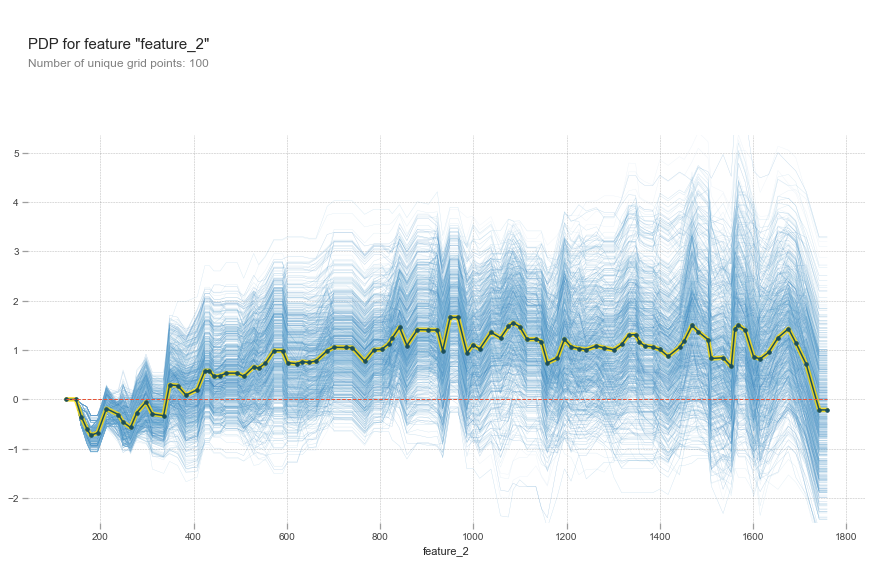

In [13]:
# Single variable plots (takes a few seconds to compute)
pdp_dist = pdp.pdp_isolate(model=bst, dataset=X_train,      
                           model_features=X_train.iloc[: , 2:].columns,
                           feature='feature_2', 
                           num_grid_points=100,
                           predict_kwds={"ignore_gp_model": True})
pdp.pdp_plot(pdp_dist, 'feature_2', plot_lines=True);

In [14]:
pred.keys()

dict_keys(['fixed_effect', 'random_effect_mean', 'random_effect_cov', 'response_mean', 'response_var'])

In [19]:
pred['random_effect_mean']

array([ 0.02220974, -0.01037426,  0.        ,  0.02984239,  0.        ,
        0.        , -0.01009438,  0.        , -0.01317603,  0.        ,
        0.00179483,  0.        ,  0.01263725,  0.        , -0.00284449,
        0.        ,  0.01293392, -0.0058978 , -0.01607773,  0.05851442,
        0.        , -0.0276279 ,  0.        ,  0.        ,  0.01921535,
        0.        ,  0.01237206,  0.        ,  0.02017012, -0.00889291,
       -0.02309766,  0.        ,  0.        ,  0.01743886,  0.        ,
        0.        ,  0.00866817,  0.        , -0.01897675,  0.03192423,
        0.002221  , -0.02259115,  0.        ,  0.        ,  0.        ,
       -0.00918069, -0.00964003, -0.00831612, -0.01046706, -0.01929602,
        0.03015654,  0.00147346,  0.02167807,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00038816,  0.01021076,
        0.        ,  0.        ,  0.00788496, -0.03318543,  0.        ,
        0.        ,  0.01680151,  0.        ,  0.        ,  0.02

In [16]:
pred['fixed_effect']

array([5.81899008, 4.00517014, 4.41354527, 5.47507222, 1.3751439 ,
       3.2470201 , 5.14578095, 5.27778707, 4.00345565, 6.4183092 ,
       4.16718582, 4.54964254, 4.55352836, 3.88848155, 6.11447118,
       5.03476931, 5.65097324, 3.60757758, 5.97133214, 4.5189604 ,
       6.11380698, 2.96434074, 1.72957084, 4.59489399, 6.1161177 ,
       5.10013116, 4.42323971, 3.80775152, 6.70658269, 5.7561972 ,
       3.94985993, 5.08629812, 6.35206119, 5.48519217, 3.12000613,
       3.71067134, 5.71752538, 4.6580236 , 2.83287432, 3.4658175 ,
       4.04226448, 4.03055613, 3.86180225, 5.018664  , 7.49067512,
       4.277766  , 4.601158  , 3.98080267, 5.80653122, 6.05394815,
       4.21983285, 4.52136016, 4.88457795, 5.74075181, 4.52935375,
       3.50654756, 1.9129176 , 6.46094858, 5.34481775, 5.09797898,
       2.32377642, 4.09700111, 3.2446378 , 4.19748805, 5.66106668,
       3.19386031, 4.71746908, 6.04651397, 4.43863576, 4.13380265,
       4.37194409, 5.19993736, 0.32516797, 3.35896615, 3.48303

## Initial experiments - Small data setting (only 10 observations per group)

In [259]:
# Generate data
n, m = 500, 50  # Number of observations and groups
p = int(n/m) # Number of observations per group
n_datasets = 20 
n_valid = 5
datasets, validation_datasets = generate_datasets(n, m, p, n_datasets, n_valid, func='linear_func', random_state=600, shared_gp=True)

# Create groups
groups = np.arange(n)
for i in range(m):
    groups[i*p:(i+1)*p] = i

# Create times for validation datasets
times = np.tile(np.arange(p)*10+10, m)

## GPBoost hyperparameter tuning

### Random Intercept model

In [4]:
# Random slope
gp_model = gpb.GPModel(group_data=np.column_stack((groups, times)))
# Candidate parameter grid
param_grid = {'learning_rate': [0.01, 0.1, 0.5, 1], 
              'max_depth': [1, 2, 3, 4, 5, 10, 50],
              'min_data_in_leaf': [1, 10, 20, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}

opt_params = grid_search_tune_parameters_multiple(param_grid=param_grid,
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=0,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
                                                  
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 112 parameter combinations...


 |--------------------------------------------------| 0.8929% 



 |█-------------------------------------------------| 1.7857% 



 |█-------------------------------------------------| 2.6786% 



 |██------------------------------------------------| 3.5714% 



 |██------------------------------------------------| 4.4643% 



 |███-----------------------------------------------| 5.3571% 



 |███-----------------------------------------------| 6.2500% 



 |████----------------------------------------------| 7.1429% 



 |████----------------------------------------------| 8.0357% 



 |████----------------------------------------------| 8.9286% 



 |█████---------------------------------------------| 9.8214% 



 |█████---------------------------------------------| 10.7143% 



 |██████--------------------------------------------| 11.6071% 



 |██████--------------------------------------------| 12.5000% 



 

### GPBoost with independent GPs

In [3]:
# Independent GP
gp_model = gpb.GPModel(group_data=groups, gp_coords=times, cluster_ids=groups, cov_function='matern', cov_fct_shape=2.5)

# Candidate parameter grid
param_grid = {'learning_rate': [0.01, 0.1, 0.5, 1], 
              'max_depth': [1, 2, 3, 4, 5, 10, 50],
              'min_data_in_leaf': [1, 10, 20, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}

opt_params = grid_search_tune_parameters_multiple(param_grid=param_grid,
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=1,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
                                                  
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 112 parameter combinations...


 |--------------------------------------------------| 0.8929% 

Trying parameter combination 1 of 112: {'learning_rate': 0.01, 'max_depth': 1, 'min_data_in_leaf': 1} ...
***** New best score (1.5870277231983096) found for the following parameter combination:
{'learning_rate': 0.01, 'max_depth': 1, 'min_data_in_leaf': 1, 'num_boost_round': 999.0}


 |█-------------------------------------------------| 1.7857% 

Trying parameter combination 2 of 112: {'learning_rate': 0.1, 'max_depth': 1, 'min_data_in_leaf': 1} ...
***** New best score (1.574858524762093) found for the following parameter combination:
{'learning_rate': 0.1, 'max_depth': 1, 'min_data_in_leaf': 1, 'num_boost_round': 164.6}


 |█-------------------------------------------------| 2.6786% 

Trying parameter combination 3 of 112: {'learning_rate': 0.5, 'max_depth': 1, 'min_data_in_leaf': 1} ...
***** New best score (1.573184314559246) found for the followi

### GPBoost with shared GPs

In [4]:
# Shared GP
gp_model = gpb.GPModel(group_data=groups, gp_coords=times, cov_function='matern', cov_fct_shape=2.5)

# Use the same hyperparameters as for Independent GP and only cross-validate to find num_boost_round
params = {'learning_rate': 0.1,
          'max_depth': 2,
          'min_data_in_leaf': 20,
          'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}

opt_params = grid_search_tune_parameters_multiple(param_grid={},
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=gp_model,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets['data_train'],
                                                  verbose_eval=1,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
                                                  
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 1 parameter combinations...


 |██████████████████████████████████████████████████| 100.0000% 


Trying parameter combination 1 of 1: {} ...
***** New best score (1.5530879253987113) found for the following parameter combination:
{'num_boost_round': 95.2}
Best number of iterations:  95.2
Best score:  1.5530879253987113
Best parameters:  {}


### Gradient-boosted trees including groups as a categorical variable

In [6]:
# GBT with grouping variable as a categorical feature
datasets_cat, validation_datasets_cat = generate_datasets(n, m, p, n_datasets, n_valid, func='make_friedman3', random_state=60, include_cat_feature=True)

# Candidate parameter grid
param_grid = {'num_leaves': [10, 20, 50, 200, 500, 1000, 5000, 2**10], 
              'max_depth': [1, 2, 3, 4, 5, 10, 50],
              'min_data_in_leaf': [1, 5, 10, 20, 30, 50]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2',
          'verbose': 0,
          'learning_rate' : 0.10}
          #'device_type' : 'gpu'}

opt_params = grid_search_tune_parameters_multiple(param_grid=param_grid,
                                                  params=params,
                                                  nfold=5,
                                                  gp_model=None,
                                                  use_gp_model_for_validation=True,
                                                  train_sets=validation_datasets_cat['data_train'],
                                                  verbose_eval=1,
                                                  num_boost_round=1000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse')
                                                  
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 336 parameter combinations...


 |--------------------------------------------------| 0.2976% 

Trying parameter combination 1 of 336: {'num_leaves': 10, 'max_depth': 1, 'min_data_in_leaf': 1} ...
***** New best score (1.593675135547522) found for the following parameter combination:
{'num_leaves': 10, 'max_depth': 1, 'min_data_in_leaf': 1, 'num_boost_round': 155.6}


 |--------------------------------------------------| 0.5952% 

Trying parameter combination 2 of 336: {'num_leaves': 20, 'max_depth': 1, 'min_data_in_leaf': 1} ...


 |--------------------------------------------------| 0.8929% 

Trying parameter combination 3 of 336: {'num_leaves': 50, 'max_depth': 1, 'min_data_in_leaf': 1} ...


 |█-------------------------------------------------| 1.1905% 

Trying parameter combination 4 of 336: {'num_leaves': 200, 'max_depth': 1, 'min_data_in_leaf': 1} ...


 |█-------------------------------------------------| 1.4881% 

Trying parameter combin

In [260]:
# Create results dataframe
results_1 = pd.DataFrame(columns=["RMSE Interpolation (mean)", "RMSE Interpolation (std)", "RMSE Extrapolation (mean)", "RMSE Extrapolation (std)", "RMSE_F (mean)", "RMSE_F (std)", "Time"],
                         index=["Linear Mixed Effects Model with no fixed features (random intercept)",
                                "Linear Mixed Effects Model with Random Intercept",
                                "Linear Mixed Effects Model with Shared Gaussian Process (Matern-5/2)",
                                "Linear Mixed Effects Model with Independent Gaussian Process (Matern-5/2)",
                                'Gradient-boosted tree with group as categorical variable (no random effects)',
                                "GPBoost with Random Intercept",
                                "GPBoost with Shared Gaussian Process (Matern-5/2)",
                                "GPBoost with Independent Gaussian Process (Matern-5/2)"])

In [261]:
# 1. Linear Mixed Effects Model with no fixed features (random intercept)
time_list, RMSE_list1, RMSE_list2 = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=False, no_features=True)

results_1.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "Time"] = np.mean(time_list)
results_1.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["Linear Mixed Effects Model with no fixed features (random intercept)", "RMSE Interpolation (std)"] = np.std(RMSE_list2)

  0%|          | 0/20 [00:00<?, ?it/s]

In [262]:
# 2. Linear Mixed Effects Model with Random Intercept
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=False)

results_1.loc["Linear Mixed Effects Model with Random Intercept", "Time"] = np.mean(time_list)
results_1.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["Linear Mixed Effects Model with Random Intercept", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc["Linear Mixed Effects Model with Random Intercept", "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc["Linear Mixed Effects Model with Random Intercept", "RMSE_F (std)"] = np.std(F_list)

  0%|          | 0/20 [00:00<?, ?it/s]

In [263]:
# 3. Linear Mixed Effects Model with Shared Gaussian Process and Matern-5/2 kernel
mod_name = 'Linear Mixed Effects Model with Shared Gaussian Process (Matern-5/2)'
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=True, shared=True, kernel='exponential')#, matern_param=2.5)

results_1.loc[mod_name, "Time"] = np.mean(time_list)
results_1.loc[mod_name, "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc[mod_name, "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc[mod_name, "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc[mod_name, "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc[mod_name, "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc[mod_name, "RMSE_F (std)"] = np.std(F_list)

  0%|          | 0/20 [00:00<?, ?it/s]

In [264]:
# 4. Linear Mixed Effects Model with Individual Gaussian Process and Matern-5/2 kernel
mod_name = 'Linear Mixed Effects Model with Individual Gaussian Process (Matern-5/2)'
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, merf=False, linear=True, GP=True, shared=False, kernel='matern', matern_param=2.5)

results_1.loc[mod_name, "Time"] = np.mean(time_list)
results_1.loc[mod_name, "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc[mod_name, "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc[mod_name, "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc[mod_name, "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc[mod_name, "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc[mod_name, "RMSE_F (std)"] = np.std(F_list)

  0%|          | 0/20 [00:00<?, ?it/s]

In [265]:
# 5. Gradient tree-boosting including the grouping variable as a categorical variable ('Boosting_Cat')
datasets_cat, validation_datasets_cat = generate_datasets(n, m, p, n_datasets, n_valid, func='make_friedman3', random_state=60, include_cat_feature=True)
params = {'num_leaves': 10, 'max_depth': 10, 'min_data_in_leaf': 5}
time_list, RMSE_list1, RMSE_list2, _ = train_and_test(datasets_cat, n_datasets, merf=False, GPBoost_cat=True, linear=False, GP=False, num_boost_round=50, params=params)

results_1.loc["Gradient-boosted tree with group as categorical variable (no random effects)", "Time"] = np.mean(time_list)
results_1.loc["Gradient-boosted tree with group as categorical variable (no random effects)", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["Gradient-boosted tree with group as categorical variable (no random effects)", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["Gradient-boosted tree with group as categorical variable (no random effects)", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["Gradient-boosted tree with group as categorical variable (no random effects)", "RMSE Interpolation (std)"] = np.std(RMSE_list2) 

  0%|          | 0/20 [00:00<?, ?it/s]

[GPBoost] [Info] Total Bins 536
[GPBoost] [Info] Number of data points in the train set: 300, number of used features: 6
[GPBoost] [Info] Start training from score 5.353720
Error encountered
[GPBoost] [Info] Total Bins 535
[GPBoost] [Info] Number of data points in the train set: 300, number of used features: 6
[GPBoost] [Info] Start training from score 5.787741
Error encountered
[GPBoost] [Info] Total Bins 535
[GPBoost] [Info] Number of data points in the train set: 300, number of used features: 6
[GPBoost] [Info] Start training from score 5.279032
Error encountered
[GPBoost] [Info] Total Bins 535
[GPBoost] [Info] Number of data points in the train set: 300, number of used features: 6
[GPBoost] [Info] Start training from score 5.574934
Error encountered
[GPBoost] [Info] Total Bins 536
[GPBoost] [Info] Number of data points in the train set: 300, number of used features: 6
[GPBoost] [Info] Start training from score 4.888584
Error encountered
[GPBoost] [Info] Total Bins 536
[GPBoost] [In

In [266]:
# 6. GPBoost with Random Intercept
params = {'learning_rate': 0.1, 'max_depth': 2, 'min_data_in_leaf': 20}
          
time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=92, params=params, merf=False, linear=False, GP=False)
results_1.loc["GPBoost with Random Intercept", "Time"] = np.mean(time_list)
results_1.loc["GPBoost with Random Intercept", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["GPBoost with Random Intercept", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["GPBoost with Random Intercept", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["GPBoost with Random Intercept", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc["GPBoost with Random Intercept", "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc["GPBoost with Random Intercept", "RMSE_F (std)"] = np.std(F_list)

  0%|          | 0/20 [00:00<?, ?it/s]

[GPBoost] [Info] Total Bins 404
[GPBoost] [Info] Number of data points in the train set: 300, number of used features: 4
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=6.281851
[GPBoost] [Info] Start training from score 6.281851
[GPBoost] [Info] Total Bins 404
[GPBoost] [Info] Number of data points in the train set: 300, number of used features: 4
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=6.500485
[GPBoost] [Info] Start training from score 6.500485
[GPBoost] [Info] Total Bins 404
[GPBoost] [Info] Number of data points in the train set: 300, number of used features: 4
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=6.732706
[GPBoost] [Info] Start training from score 6.732706
[GPBoost] [Info] Total Bins 404
[GPBoost] [Info] Number of data points in the train set: 300, number of used features: 4
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=7.031932
[GPBoost] [Info] Start training from score 7.031932
[GPBoost] [Info] Tot

In [267]:
# 7. GPBoost with Shared Gaussian Process
params = params = {'learning_rate': 0.1,
          'max_depth': 2,
          'min_data_in_leaf': 20,
          'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}

time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=95, params=params, merf=False, linear=False, GP=True, shared=True, kernel='exponential')#, matern_param=2.5)
results_1.loc["GPBoost with Shared Gaussian Process (Matern-5/2)", "Time"] = np.mean(time_list)
results_1.loc["GPBoost with Shared Gaussian Process (Matern-5/2)", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["GPBoost with Shared Gaussian Process (Matern-5/2)", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["GPBoost with Shared Gaussian Process (Matern-5/2)", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["GPBoost with Shared Gaussian Process (Matern-5/2)", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc["GPBoost with Shared Gaussian Process (Matern-5/2)", "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc["GPBoost with Shared Gaussian Process (Matern-5/2)", "RMSE_F (std)"] = np.std(F_list)

  0%|          | 0/20 [00:00<?, ?it/s]

In [268]:
# 8. GPBoost with Independent Gaussian Process
params = params = {'learning_rate': 0.1,
          'max_depth': 2,
          'min_data_in_leaf': 20,
          'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}

time_list, RMSE_list1, RMSE_list2, F_list = train_and_test(datasets, n_datasets, num_boost_round=98, params=params, merf=False, linear=False, GP=True, shared=False, kernel='matern', matern_param=2.5)
results_1.loc["GPBoost with Independent Gaussian Process (Matern-5/2)", "Time"] = np.mean(time_list)
results_1.loc["GPBoost with Independent Gaussian Process (Matern-5/2)", "RMSE Extrapolation (mean)"] = np.mean(RMSE_list1)
results_1.loc["GPBoost with Independent Gaussian Process (Matern-5/2)", "RMSE Extrapolation (std)"] = np.std(RMSE_list1)
results_1.loc["GPBoost with Independent Gaussian Process (Matern-5/2)", "RMSE Interpolation (mean)"] = np.mean(RMSE_list2)
results_1.loc["GPBoost with Independent Gaussian Process (Matern-5/2)", "RMSE Interpolation (std)"] = np.std(RMSE_list2)
results_1.loc["GPBoost with Independent Gaussian Process (Matern-5/2)", "RMSE_F (mean)"] = np.mean(F_list)
results_1.loc["GPBoost with Independent Gaussian Process (Matern-5/2)", "RMSE_F (std)"] = np.std(F_list)

  0%|          | 0/20 [00:00<?, ?it/s]

In [258]:
results_1

,RMSE Interpolation (mean),RMSE Interpolation (std),RMSE Extrapolation (mean),RMSE Extrapolation (std),RMSE_F (mean),RMSE_F (std),Time
Linear Mixed Effects Model with no fixed features (random intercept),NaN,NaN,NaN,NaN,NaN,NaN,NaN
Linear Mixed Effects Model with Random Intercept,1.933882,0.115181,1.925215,0.15924,1.99281,0.209641,0.009013
Linear Mixed Effects Model with Shared Gaussian Process (Matern-5/2),1.431079,0.0976,1.651808,0.123189,2.142109,0.221728,0.296951
Linear Mixed Effects Model with Independent Gaussian Process (Matern-5/2),NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gradient-boosted tree with group as categorical variable (no random effects),1.677821,0.133945,1.652498,0.171282,NaN,NaN,0.01422
GPBoost with Random Intercept,1.877661,0.112879,1.887402,0.159056,1.629068,0.203446,0.079462
GPBoost with Shared Gaussian Process (Matern-5/2),1.366012,0.116565,1.624075,0.119808,1.649195,0.209142,2.05563
GPBoost with Independent Gaussian Process (Matern-5/2),1.688903,0.129164,1.916527,0.137548,1.623008,0.197606,0.217051


In [270]:
results_1

,RMSE Interpolation (mean),RMSE Interpolation (std),RMSE Extrapolation (mean),RMSE Extrapolation (std),RMSE_F (mean),RMSE_F (std),Time
Linear Mixed Effects Model with no fixed features (random intercept),2.108044,0.141821,2.035445,0.171046,NaN,NaN,0.00519
Linear Mixed Effects Model with Random Intercept,1.826743,0.098057,1.809935,0.153795,2.089349,0.152398,0.005249
Linear Mixed Effects Model with Shared Gaussian Process (Matern-5/2),1.265801,0.101482,1.526399,0.124059,2.231006,0.155591,0.33265
Linear Mixed Effects Model with Independent Gaussian Process (Matern-5/2),NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gradient-boosted tree with group as categorical variable (no random effects),1.677821,0.133945,1.652498,0.171282,NaN,NaN,0.015824
GPBoost with Random Intercept,1.875871,0.11025,1.860021,0.146056,1.59073,0.195939,0.100073
GPBoost with Shared Gaussian Process (Matern-5/2),1.330119,0.102673,1.578037,0.119197,1.597899,0.20125,2.334501
GPBoost with Independent Gaussian Process (Matern-5/2),1.680513,0.122585,1.891899,0.130496,1.578501,0.187303,0.224287
Linear Mixed Effects Model with Individual Gaussian Process (Matern-5/2),1.629808,0.110683,1.843694,0.146267,2.069733,0.143249,0.081805
